**3 - Détailler le gain de consommation dû à un changement de classe de DPE par usage : chauffage, eau chaude sanitaire, refroidissement, éclairage, autres (ces détails sont présents dans les données de DPE)**

# Librairies

In [ ]:
import pandas as pd
import re
import unicodedata
from unidecode import unidecode
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import plotly.express as px

In [ ]:
pd.set_option('display.max_columns', None)

# Importation des données

In [ ]:
path = '/content/drive/MyDrive/PIP 2025/Rendu final/Problématique 3'

In [ ]:
dpe3 = pd.read_csv(path + '/#dpe_pb3.csv', sep=',')

In [ ]:
dpe3.shape

(1415691, 20)

# Couleurs DPE

In [ ]:
# Couleurs officielles des classes DPE
dpe_colors = {
    'A': '#00cc00',  # Vert foncé
    'B': '#66ff66',  # Vert clair
    'C': '#ffff00',  # Jaune
    'D': '#ffcc00',  # Orange clair
    'E': '#ff9900',  # Orange foncé
    'F': '#ff3300',  # Rouge clair
    'G': '#cc0000'   # Rouge foncé
}

# Liste des colonnes

In [ ]:
dpe3.columns.to_list()

['Etiquette_DPE',
 'Surface_habitable_logement',
 'Type_énergie_n°1',
 'Type_bâtiment',
 'Adresse_(BAN)',
 'N°_département_(BAN)',
 'Coordonnée_cartographique_X_(BAN)',
 'Coordonnée_cartographique_Y_(BAN)',
 'N°_voie_(BAN)',
 'Nom__rue_(BAN)',
 'Nom__commune_(BAN)',
 'Conso_chauffage_é_finale',
 'Conso_chauffage_é_finale_énergie_n°1',
 'Conso_ECS_é_finale',
 'Conso_ECS_é_finale_énergie_n°1',
 'Conso_refroidissement_é_finale',
 'Conso_éclairage_é_finale',
 'Conso_auxiliaires_é_finale',
 'Conso_5_usages_é_finale',
 'Conso_5_usages_é_finale_énergie_n°1']

# GAIN

## Filtrer les colonnes pertinentes

In [ ]:
colonnes_interet = [
    'Etiquette_DPE',
    'Conso_chauffage_é_finale',
    'Conso_ECS_é_finale',
    'Conso_refroidissement_é_finale',
    'Conso_éclairage_é_finale',
    'Conso_auxiliaires_é_finale',
    'Conso_5_usages_é_finale',
    'Surface_habitable_logement'
]

df_filtre = dpe3[colonnes_interet]

## Consommations par m²

In [ ]:
df_filtre.iloc[:, 1:7] = df_filtre.iloc[:, 1:7].div(df_filtre['Surface_habitable_logement'], axis=0)

## Regrouper par classe DPE et calculer la moyenne des consommations

In [ ]:
consommation_par_dpe = df_filtre.groupby('Etiquette_DPE').mean()

## Trier les classes DPE dans l'ordre (A à G)

In [ ]:
consommation_par_dpe = consommation_par_dpe.sort_index()

## Créer un tableau de comparaison entre toutes les classes

In [ ]:
comparaisons = []
classes = consommation_par_dpe.index.tolist()

for usage in consommation_par_dpe.columns[:-1]:  # Exclure la surface habitable
    for classe_arrivee in classes:
        for classe_depart in classes:
            difference = consommation_par_dpe.loc[classe_depart, usage] - consommation_par_dpe.loc[classe_arrivee, usage]
            comparaisons.append({
                'De': classe_depart,
                'Vers': classe_arrivee,
                'Usage': usage,
                'Différence': difference
            })

## Convertir la liste en DataFrame

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
comparaisons_df = pd.DataFrame(comparaisons)

# Tracer un graphique en barres pour chaque usage et classe d'arrivée

### en %

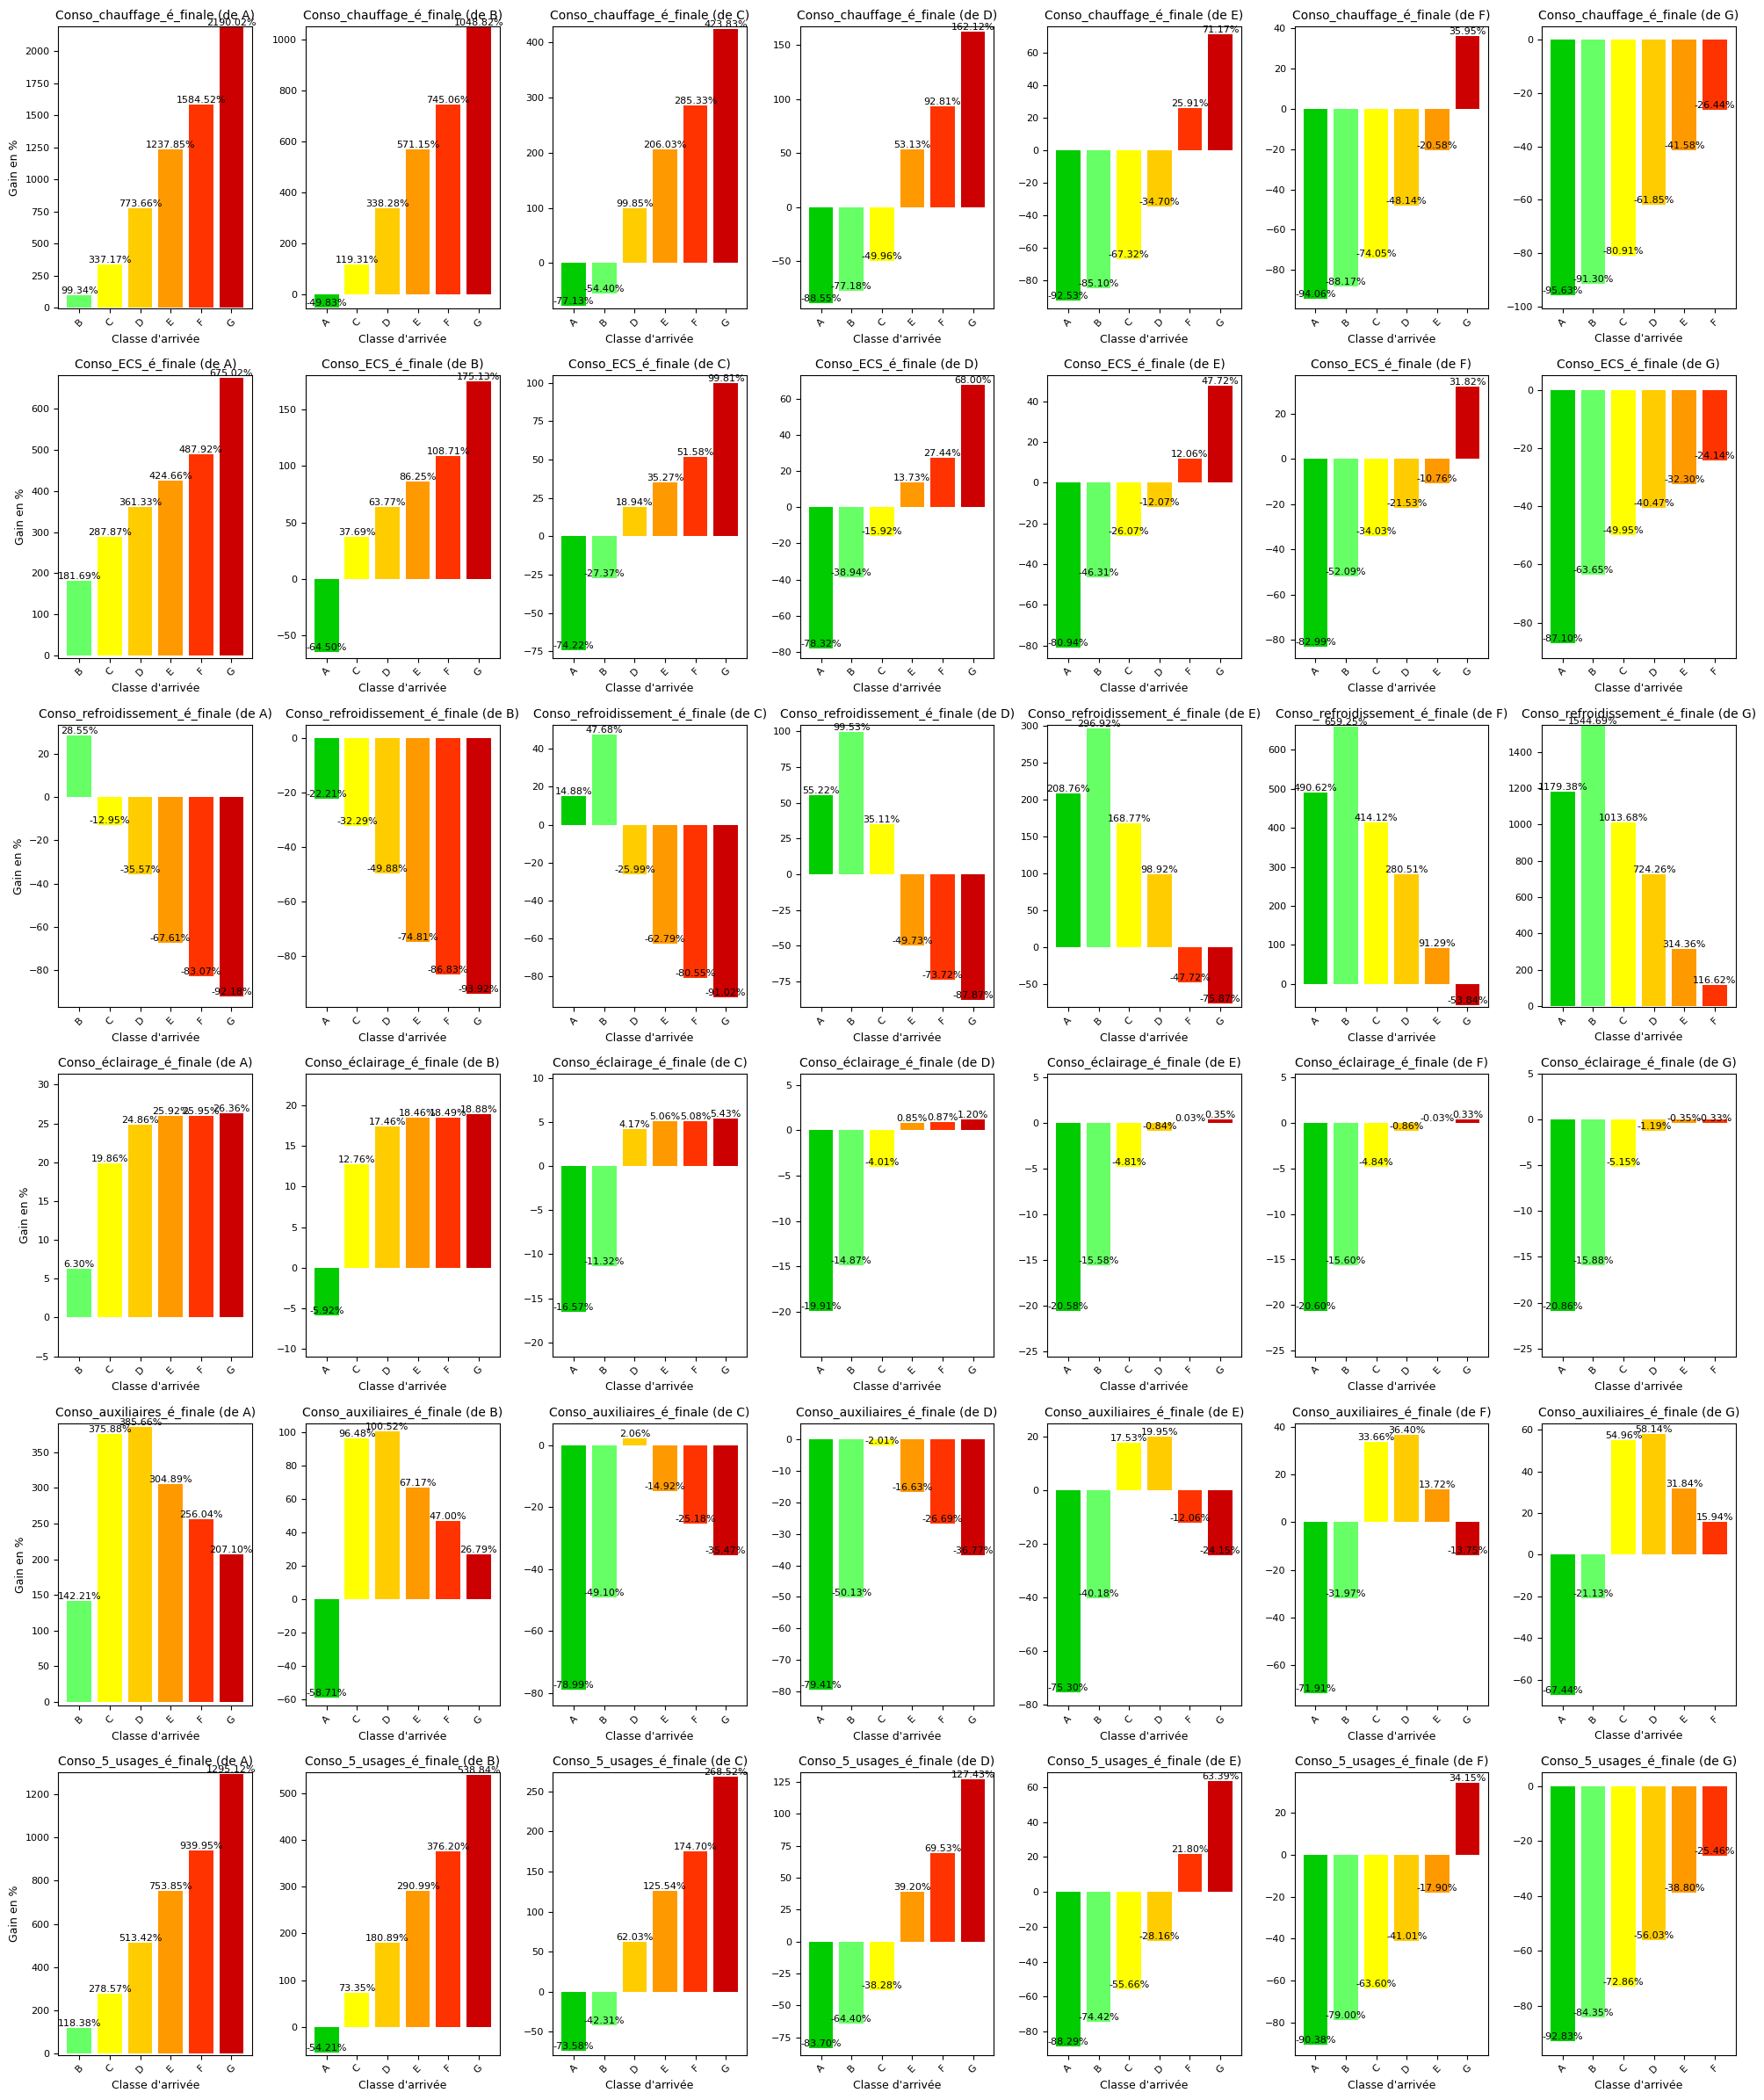

In [ ]:
import matplotlib.pyplot as plt

# Liste des usages (colonnes de consommation à traiter)
usages = consommation_par_dpe.columns[:-1]  # Exclure la surface habitable

# Création de la figure avec un sous-graphe par usage et classe
fig, axes = plt.subplots(
    len(usages), len(classes), figsize=(20, 4 * len(usages)), sharey=False
)

for i, usage in enumerate(usages):  # Boucle sur les usages
    for j, label in enumerate(classes):  # Boucle sur les classes de départ
        gain_percentage = []
        comparison_labels = []

        for other_label in classes:
            if label != other_label:
                base_value = consommation_par_dpe.loc[label, usage]
                if base_value != 0:  # Éviter la division par zéro
                    gain_pct = (
                        (consommation_par_dpe.loc[other_label, usage] - base_value)
                        / base_value
                    ) * 100
                    gain_percentage.append(gain_pct)
                    comparison_labels.append(other_label)

        # Associer les couleurs selon les DPE
        colors = [dpe_colors[dpe] for dpe in comparison_labels]

        # Récupérer l'axe correspondant
        ax = axes[i, j] if len(usages) > 1 else axes[j]  # Ajuster pour une seule ligne

        # Graphique en barres
        bars_pct = ax.bar(comparison_labels, gain_percentage, color=colors)
        ax.set_title(f"{usage} (de {label})", fontsize=10)
        ax.set_xlabel("Classe d'arrivée", fontsize=9)
        if j == 0:
            ax.set_ylabel("Gain en %", fontsize=9)
        ax.tick_params(axis="x", rotation=45, labelsize=8)
        ax.tick_params(axis="y", labelsize=8)

        # Définir dynamiquement les limites des axes Y en fonction des données
        if gain_percentage:
            ymin = min(0, min(gain_percentage))  # Inclure 0 pour les gains négatifs
            ymax = max(0, max(gain_percentage))  # Inclure 0 pour les gains positifs
            ax.set_ylim(ymin - 5, ymax + 5)  # Ajouter un léger padding

        # Ajouter les valeurs au-dessus des barres
        for bar, h in zip(bars_pct, gain_percentage):
            yval = bar.get_height()
            ax.text(bar.get_x() + bar.get_width() / 2.0, yval, f'{h:.2f}%', ha='center', va='bottom', fontsize=8)

# Réglages pour l'espacement
plt.tight_layout()
plt.show()
